## Часть 5. Заключительная.
### Построение наиболее качественной модели для соревнования на площадке Kaggle.

Предыдущие части 1, 2, 3, 4 доступны по ссылке

https://github.com/Anokiro/additional/pull/7

In [16]:
"""Нумерация потоков вывода не последовательна, смотреть на общий ход выполнения"""

In [2]:
import time
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from scipy.stats import gmean, rankdata

from sklearn.metrics import roc_auc_score, plot_roc_curve

import xgboost as xgb
import catboost as ctb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from boostaroota import BoostARoota
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка и небольшое преобразование данных перед подачей в модель ---------------------------------------------------->>>

In [3]:
train_old = pd.read_csv(r"./competitive-data-analysis_coursework/train.csv")
test_old = pd.read_csv(r"./competitive-data-analysis_coursework/test.csv")
profile = pd.read_csv(r"./competitive-data-analysis_coursework/client_profile.csv")

In [4]:
my_train_old = pd.merge(train_old, profile, on='APPLICATION_NUMBER', how='left')
my_test_old = pd.merge(test_old, profile, on='APPLICATION_NUMBER', how='left')

In [5]:
my_train_old.head(1)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123687442,0,Cash,M,1.0,157500.0,855000.0,25128.0,Secondary / secondary special,Married,...,3.0,0.700784,0.645914,0.71657,0.0,0.0,1.0,0.0,0.0,2.0


In [6]:
my_test_old.head(1)

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123724268,Cash,M,0.0,117000.0,1125000.0,32895.0,Secondary / secondary special,Married,0.028663,...,2.0,NaN,0.628266,NaN,0.0,0.0,0.0,0.0,1.0,4.0


In [7]:
def get_preparate_data(my_train_old):
    # LabelEncoding категориальных признаков ---->
    # Пол
    list_replace_gender = {'F': '0', 'M': '1', 'XNA': '1'}
    my_train_old['GENDER'] = my_train_old['GENDER'].map(list_replace_gender)
    my_train_old['GENDER'] = my_train_old['GENDER'].astype('float')
    
    # Тип выплаты
    list_replace_nct = {'Cash': '0', 'Credit Card': '1'}
    my_train_old['NAME_CONTRACT_TYPE'] = my_train_old['NAME_CONTRACT_TYPE'].map(list_replace_nct)
    my_train_old['NAME_CONTRACT_TYPE'] = my_train_old['NAME_CONTRACT_TYPE'].astype('float')
    
    # Уровень образования
    list_replace_ed = {'Secondary / secondary special': '0', 'Higher education': '1',
           'Incomplete higher': '2', 'Lower secondary': '3', 'Academic degree': '4'}
    my_train_old['EDUCATION_LEVEL'] = my_train_old['EDUCATION_LEVEL'].map(list_replace_ed)
    my_train_old['EDUCATION_LEVEL'] = my_train_old['EDUCATION_LEVEL'].astype('float')
    
    # Семейный статус
    list_replace_st = {'Married': '0', 'Single / not married': '1', 'Civil marriage': '2', 'Separated': '3',
           'Widow': '4', 'Unknown': '4'}
    my_train_old['FAMILY_STATUS'] = my_train_old['FAMILY_STATUS'].map(list_replace_st)
    my_train_old['FAMILY_STATUS'] = my_train_old['FAMILY_STATUS'].astype('float')
    
    # Замена пропусков и выбросов ---->
    my_train_old.fillna(-1, inplace=True)
    my_train_old['DAYS_ON_LAST_JOB'].replace(365243, -1, inplace=True)
    
    # Формирование новых признаков ---->
    # Количество периодов выплаты кредита
    my_train_old['AMOUNT_CREDIT/AMOUNT_ANNUITY'] = my_train_old['AMOUNT_CREDIT'] / my_train_old['AMOUNT_ANNUITY']
    my_train_old['AMOUNT_CREDIT/AMOUNT_ANNUITY'].replace(1, -1, inplace=True)
    
    # Средний внешний кредитный рейтинг
    my_train_old['mean_EXTERNAL'] = (my_train_old['EXTERNAL_SCORING_RATING_1'] + my_train_old['EXTERNAL_SCORING_RATING_2'] + my_train_old['EXTERNAL_SCORING_RATING_3']) / 3
    
    # Объединенный семейный статус с количеством детей ('str')
    my_train_old['CHILDRENS+STATUS'] = my_train_old['CHILDRENS'].astype('str') + my_train_old['FAMILY_STATUS'].astype('str')
    if 'TARGET' in my_train_old.columns.tolist():
        hash_space = 0.1
        for item_column in my_train_old.drop('TARGET', axis=1).select_dtypes(include=['object', 'category']).columns.tolist():
            for itm in my_train_old[item_column].value_counts().index.tolist():
                my_train_old.loc[my_train_old[item_column] == itm, item_column] = (hash(itm) % hash_space)
            my_train_old[item_column] = my_train_old[item_column].astype('float')
    
    if 'TARGET' not in my_train_old.columns.tolist():
        hash_space = 0.1
        for item_column in my_train_old.select_dtypes(include=['object', 'category']).columns.tolist():
            for itm in my_train_old[item_column].value_counts().index.tolist():
                my_train_old.loc[my_train_old[item_column] == itm, item_column] = (hash(itm) % hash_space)
            my_train_old[item_column] = my_train_old[item_column].astype('float')
    
    #остаток средств после уплаты ежем взноса
    my_train_old['mounth_SALARY'] = (my_train_old['TOTAL_SALARY'] / [12 if ii != -1 else 0 for ii in my_train_old['TOTAL_SALARY'].values]) - \
    (my_train_old['AMOUNT_ANNUITY'] / [12 if ii != -1 else 0 for ii in my_train_old['AMOUNT_ANNUITY'].values])
    my_train_old['mounth_SALARY'].fillna(-1, inplace=True)
    
    
    # Преобразование признаков для дальнейшего дамми-кодирования ---->
    my_train_old = my_train_old.replace([-np.inf, np.inf], [0, 0])
    
    my_train_old['EXTERNAL_SCORING_RATING_1'] = round(my_train_old['EXTERNAL_SCORING_RATING_1'], 3)
    my_train_old['EXTERNAL_SCORING_RATING_2'] = round(my_train_old['EXTERNAL_SCORING_RATING_2'], 3)
    my_train_old['EXTERNAL_SCORING_RATING_3'] = round(my_train_old['EXTERNAL_SCORING_RATING_3'], 3)
    my_train_old['mean_EXTERNAL'] = round(my_train_old['mean_EXTERNAL'], 3)

    my_train_old['AMOUNT_CREDIT/AMOUNT_ANNUITY'] = round(my_train_old['AMOUNT_CREDIT/AMOUNT_ANNUITY'], 1)

    for feature in ['TOTAL_SALARY', 'AMOUNT_CREDIT', 'AMOUNT_ANNUITY', 'mounth_SALARY']:
        my_train_old.loc[my_train_old[feature] > my_train_old[feature].quantile(0.99999), feature] = my_train_old[feature].quantile(0.99999)
        my_train_old[feature] = round(my_train_old[feature] / 1000) * 1000

    my_train_old['AGE'] = (my_train_old['AGE'] / 365.25).astype('int')
    my_train_old['DAYS_ON_LAST_JOB'] = (my_train_old['DAYS_ON_LAST_JOB'] / 365.25).astype('int')
    
    return my_train_old

In [8]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
  
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)
        y_valid_pred = estimator.predict_proba(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred[:,1]))
        fold_valid_scores.append(metric(y_valid, y_valid_pred[:,1]))
        oof_predictions[valid_idx] = y_valid_pred[:,1]

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")
    
    print(estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions)
    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [9]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=75,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=100,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [10]:
my_train_old = get_preparate_data(my_train_old)
my_test_old = get_preparate_data(my_test_old)

In [ ]:
# Обработка признаков с помощью BoostARoota

In [2]:
my_train_old_dummies = my_train_old.copy()

In [3]:
my_train_old_dummies_true = my_train_old.copy()

In [6]:
my_train_old_dummies.head()

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY
0,123687442,0,0.0,1.0,1.0,158000.0,855000.0,25000.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,34.0,0.688,0.094567,11000.0
1,123597908,1,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0
2,123526683,0,0.0,0.0,0.0,135000.0,1007000.0,43000.0,1.0,0.0,...,0.0,0.0,0.0,7.0,0.0,4.0,23.6,-0.017,0.084058,8000.0
3,123710391,1,0.0,1.0,0.0,180000.0,519000.0,23000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22.6,-0.219,0.084058,13000.0
4,123590329,1,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0


In [4]:
my_train_old_dummies_true.head(2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY
0,123687442,0,0.0,1.0,1.0,158000.0,855000.0,25000.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,34.0,0.688,0.094567,11000.0
1,123597908,1,0.0,-1.0,-1.0,-0.0,-0.0,-0.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0


In [7]:
my_train_old_dummies = pd.get_dummies(my_train_old_dummies, columns = my_train_old_dummies.drop(['APPLICATION_NUMBER', 'TARGET'], axis=1).columns.tolist())


In [8]:
my_train_old_dummies = pd.merge(my_train_old_dummies, my_train_old_dummies_true.drop('TARGET', axis=1), on='APPLICATION_NUMBER', how='left')

In [9]:
my_train_old_dummies.iloc[:, 6850:6884]

,mounth_SALARY_180000.0,mounth_SALARY_182000.0,mounth_SALARY_278000.0,mounth_SALARY_309000.0,mounth_SALARY_324000.0,mounth_SALARY_365000.0,NAME_CONTRACT_TYPE,GENDER,CHILDRENS,TOTAL_SALARY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY
0,0,0,0,0,0,0,0.0,1.0,1.0,158000.0,...,0.0,0.0,1.0,0.0,0.0,2.0,34.0,0.688,0.094567,11000.0
1,0,0,0,0,0,0,0.0,-1.0,-1.0,-0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0
2,0,0,0,0,0,0,0.0,0.0,0.0,135000.0,...,0.0,0.0,0.0,7.0,0.0,4.0,23.6,-0.017,0.084058,8000.0
3,0,0,0,0,0,0,0.0,1.0,0.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,22.6,-0.219,0.084058,13000.0
4,0,0,0,0,0,0,0.0,-1.0,-1.0,-0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,0,0,0,0,0,0,0.0,-1.0,-1.0,-0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0
110089,0,0,0,0,0,0,0.0,0.0,0.0,176000.0,...,0.0,0.0,0.0,0.0,0.0,2.0,21.4,0.527,0.084058,14000.0
110090,0,0,0,0,0,0,0.0,-1.0,-1.0,-0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0
110091,0,0,0,0,0,0,0.0,0.0,2.0,270000.0,...,0.0,0.0,0.0,1.0,0.0,1.0,20.7,0.621,0.068355,18000.0


In [12]:
X = my_train_old_dummies.drop("TARGET", axis=1)
y = my_train_old_dummies["TARGET"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=99)

In [15]:
# базовая модель
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
     'n_estimators': 530,
      'learning_rate': 0.058398714404129526,
    'colsample_bytree': 0.42,
    'max_depth': 3,
    'min_child_weight': 11,
    'num_leaves': 9,
    'reg_alpha': 0.04957731249489923,
    'reg_lambda': 0.059695887114426555,
    'subsample': 0.80249, 
    'random_state': 99,
#     "early_stopping_rounds": 150
}

model_lgbm = LGBMClassifier(**lgbm_params)
model_lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=25)

[25]	training's auc: 0.712839	valid_1's auc: 0.705364
[50]	training's auc: 0.721831	valid_1's auc: 0.715011
[75]	training's auc: 0.727599	valid_1's auc: 0.720575
[100]	training's auc: 0.732186	valid_1's auc: 0.723778
[125]	training's auc: 0.735508	valid_1's auc: 0.726833
[150]	training's auc: 0.73798	valid_1's auc: 0.728411
[175]	training's auc: 0.740252	valid_1's auc: 0.729243
[200]	training's auc: 0.741955	valid_1's auc: 0.730426
[225]	training's auc: 0.743975	valid_1's auc: 0.730975
[250]	training's auc: 0.745482	valid_1's auc: 0.731283
[275]	training's auc: 0.747885	valid_1's auc: 0.73116
[300]	training's auc: 0.74951	valid_1's auc: 0.731692
[325]	training's auc: 0.750826	valid_1's auc: 0.732085
[350]	training's auc: 0.752215	valid_1's auc: 0.732341
[375]	training's auc: 0.753286	valid_1's auc: 0.732838
[400]	training's auc: 0.754458	valid_1's auc: 0.732999
[425]	training's auc: 0.755775	valid_1's auc: 0.733061
[450]	training's auc: 0.757049	valid_1's auc: 0.733037
[475]	training's

LGBMClassifier(colsample_bytree=0.42, learning_rate=0.058398714404129526,
               max_depth=3, metric='auc', min_child_weight=11, n_estimators=530,
               num_leaves=9, random_state=99, reg_alpha=0.04957731249489923,
               reg_lambda=0.059695887114426555, subsample=0.80249)

In [ ]:
# тюнинг

In [16]:
br = BoostARoota(clf=model_lgbm, metric='auc', iters=50)
br.fit(X_train, y_train)

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  1  iteration:  11
Round:  1  iteration:  12
Round:  1  iteration:  13
Round:  1  iteration:  14
Round:  1  iteration:  15
Round:  1  iteration:  16
Round:  1  iteration:  17
Round:  1  iteration:  18
Round:  1  iteration:  19
Round:  1  iteration:  20
Round:  1  iteration:  21
Round:  1  iteration:  22
Round:  1  iteration:  23
Round:  1  iteration:  24
Round:  1  iteration:  25
Round:  1  iteration:  26
Round:  1  iteration:  27
Round:  1  iteration:  28
Round:  1  iteration:  29
Round:  1  iteration:  30
Round:  1  iteration:  31
Round:  1  iteration:  32
Round:  1  iteration:  33
Round:  1  iteration:  34
Round:  1  iteration:  35
Round:  1  iteration:  36
Round:  1  iteration:  37
Round:  1  iteration:  38
Round:  1  iteration:

In [17]:
br.keep_vars_

0                APPLICATION_NUMBER
1            NAME_CONTRACT_TYPE_0.0
2            NAME_CONTRACT_TYPE_1.0
3                        GENDER_0.0
4                        GENDER_1.0
                   ...             
152      AMT_REQ_CREDIT_BUREAU_YEAR
153    AMOUNT_CREDIT/AMOUNT_ANNUITY
154                   mean_EXTERNAL
155                CHILDRENS+STATUS
156                   mounth_SALARY
Name: feature, Length: 150, dtype: object

In [ ]:
X_train_br.head()

In [ ]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
     'n_estimators': 776,
      'learning_rate': 0.03947,
    'max_depth': 3,
    'min_child_weight': 20,
    'num_leaves': 40,
    'reg_alpha': 0.04711,
    'reg_lambda': 0.05724,
    'subsample': 0.38, 
    'random_state': 99,
#     "early_stopping_rounds": 100
}

In [18]:
X_train_br = br.transform(X_train)
X_valid_br = br.transform(X_valid)

In [ ]:
model_lgbm_br2 = LGBMClassifier(**lgbm_params)
model_lgbm_br2.fit(X_train_br, y_train, eval_set=[(X_train_br, y_train), (X_valid_br, y_valid)], verbose=50)

In [ ]:
model_lgbm_br2.best_score_, model_lgbm_br2.best_iteration_

In [ ]:
# Соединить обратно для кросс-валидации

In [19]:
X_train_y = pd.concat([X_train_br, y_train], axis=1)

In [20]:
X_valid_y = pd.concat([X_valid_br, y_valid], axis=1)

In [21]:
X_all_br = pd.concat([X_train_y, X_valid_y], axis=0)
X_all_br

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_0.0,NAME_CONTRACT_TYPE_1.0,GENDER_0.0,GENDER_1.0,CHILDRENS_0.0,CHILDRENS_1.0,TOTAL_SALARY_76000.0,TOTAL_SALARY_81000.0,TOTAL_SALARY_104000.0,...,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY,TARGET
65090,123498233,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0,0
66927,123637651,0,1,1,0,0,1,0,0,0,...,0.617,0.470,0.0,0.0,0.0,20.0,0.399,0.094567,5000.0,0
6976,123475540,1,0,0,1,0,1,0,0,0,...,0.692,0.403,0.0,0.0,6.0,22.7,0.032,0.094567,6000.0,0
38304,123619981,1,0,0,1,1,0,0,0,0,...,0.532,-1.000,-1.0,-1.0,-1.0,20.5,-0.019,0.084058,54000.0,0
98604,123527347,1,0,1,0,0,1,0,0,0,...,0.321,0.169,0.0,2.0,6.0,19.6,0.266,0.094567,6000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58723,123537853,1,0,1,0,1,0,0,0,0,...,0.301,0.719,0.0,2.0,1.0,26.3,0.007,0.037038,8000.0,0
76550,123458577,1,0,1,0,0,0,0,0,0,...,0.611,0.651,0.0,0.0,2.0,10.9,0.484,0.011577,4000.0,0
25773,123677280,1,0,0,1,0,0,0,0,0,...,0.466,0.775,0.0,1.0,1.0,18.4,0.080,0.068355,10000.0,0
11780,123444063,1,0,1,0,0,1,0,0,0,...,0.035,-1.000,0.0,0.0,1.0,9.4,-0.160,0.084450,7000.0,0


In [22]:
X_all_br2 = X_all_br.reset_index().sort_values(by='index')
X_all_br2.drop('index', axis=1, inplace=True)

In [23]:
X_all_br.to_csv(r"./competitive-data-analysis_coursework/X_all_br.csv", index=False)

In [24]:
X_all_br2.to_csv(r"./competitive-data-analysis_coursework/X_all_br2.csv", index=False)

In [111]:
# В отсортированном виде
gg = X_all_br.reset_index().sort_values(by='index')

In [113]:
gg = gg.set_index('index')

In [114]:
gg

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_0.0,NAME_CONTRACT_TYPE_1.0,GENDER_0.0,GENDER_1.0,CHILDRENS_0.0,CHILDRENS_1.0,TOTAL_SALARY_76000.0,TOTAL_SALARY_81000.0,TOTAL_SALARY_104000.0,...,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY,TARGET
index,,,,,,,,,,,,,,,,,,,,,
0,123687442,1,0,0,1,0,1,0,0,0,...,0.646,0.717,0.0,0.0,2.0,34.0,0.688,0.094567,11000.0,0
1,123597908,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0,1
2,123526683,1,0,1,0,1,0,0,0,0,...,0.682,0.268,7.0,0.0,4.0,23.6,-0.017,0.084058,8000.0,0
3,123710391,1,0,0,1,1,0,0,0,0,...,0.171,0.170,0.0,0.0,0.0,22.6,-0.219,0.084058,13000.0,1
4,123590329,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0,0
110089,123672463,1,0,1,0,1,0,0,0,0,...,0.472,0.581,0.0,0.0,2.0,21.4,0.527,0.084058,14000.0,0
110090,123723001,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.046343,-0.0,0


In [115]:
gg.to_csv(r"./competitive-data-analysis_coursework/X_all_br_sortindex.csv", index=False)

In [ ]:
# Сразу подготовим тест

In [30]:
my_test_old_dummies = my_test_old.copy()

In [34]:
my_test_old_dummies_true = my_test_old_dummies.copy()

In [38]:
my_test_old_dummies = pd.get_dummies(my_test_old_dummies, columns = my_test_old_dummies.drop('APPLICATION_NUMBER', axis=1).columns.tolist())


In [40]:
my_test_old_dummies = pd.merge(my_test_old_dummies, my_test_old_dummies_true, on='APPLICATION_NUMBER', how='left')

In [45]:
my_test_old_dummies

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_0.0,NAME_CONTRACT_TYPE_1.0,GENDER_-1.0,GENDER_0.0,GENDER_1.0,CHILDRENS_-1.0,CHILDRENS_0.0,CHILDRENS_1.0,CHILDRENS_2.0,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY
0,123724268,1,0,0,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,4.0,34.2,-0.457,0.045468,7000.0
1,123456549,1,0,0,1,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,2.0,18.3,-0.078,0.006443,5000.0
2,123428178,0,1,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,6.0,20.0,-0.155,0.006443,11000.0
3,123619984,1,0,1,0,0,1,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
4,123671104,1,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,10.2,0.547,0.088874,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,1,0,1,0,0,1,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
165137,123536402,1,0,0,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,26.8,0.067,0.021008,10000.0
165138,123718238,1,0,1,0,0,1,0,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
165139,123631557,1,0,0,1,0,0,1,0,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,9.5,-0.413,0.045468,6000.0


In [47]:
# Для корректного преобразования создадим новые признаки, которых не оказалось в тесте. (в данном случай вручную)
my_test_old_dummies['CHILDRENS+STATUS_0.0844498741213137'] = 0
my_test_old_dummies['REGION_POPULATION_0.0116569999999999'] = 0
my_test_old_dummies['CHILDRENS+STATUS_0.094233227571488'] = 0
my_test_old_dummies['CHILDRENS+STATUS_0.0840579166615393'] = 0
my_test_old_dummies['CHILDRENS+STATUS_0.0254000342772685'] = 0
my_test_old_dummies['CHILDRENS+STATUS_0.0370376560690307'] = 0

In [48]:
test_br = br.transform(my_test_old_dummies)

In [49]:
test_br

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE_0.0,NAME_CONTRACT_TYPE_1.0,GENDER_0.0,GENDER_1.0,CHILDRENS_0.0,CHILDRENS_1.0,TOTAL_SALARY_76000.0,TOTAL_SALARY_81000.0,TOTAL_SALARY_104000.0,...,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMOUNT_CREDIT/AMOUNT_ANNUITY,mean_EXTERNAL,CHILDRENS+STATUS,mounth_SALARY
0,123724268,1,0,0,1,1,0,0,0,0,...,-1.000,0.628,-1.000,0.0,1.0,4.0,34.2,-0.457,0.045468,7000.0
1,123456549,1,0,1,0,0,0,0,1,0,...,-1.000,0.578,0.188,0.0,0.0,2.0,18.3,-0.078,0.006443,5000.0
2,123428178,0,1,1,0,0,0,0,0,0,...,-1.000,0.153,0.383,0.0,1.0,6.0,20.0,-0.155,0.006443,11000.0
3,123619984,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
4,123671104,1,0,1,0,0,1,0,0,0,...,0.719,0.506,0.415,0.0,1.0,0.0,10.2,0.547,0.088874,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
165137,123536402,1,0,0,1,1,0,0,0,0,...,-1.000,0.666,0.535,0.0,0.0,0.0,26.8,0.067,0.021008,10000.0
165138,123718238,1,0,0,0,0,0,0,0,0,...,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,0.043523,-0.0
165139,123631557,1,0,1,0,1,0,0,0,0,...,-1.000,0.761,-1.000,-1.0,-1.0,-1.0,9.5,-0.413,0.045468,6000.0


In [50]:
test_br.to_csv(r"./competitive-data-analysis_coursework/my_test_old_for_analys.csv", index=False)

In [ ]:
# Обучим модели на подготовленных данных

In [ ]:
# Модель lgbm 1

In [125]:
lgbm_params = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
     'n_estimators': 1032,
      'learning_rate': 0.058398,
    'colsample_bytree': 0.15,
    'max_depth': 2,
    'min_child_weight': 11,
    'num_leaves': 9,
    'reg_alpha': 0.03957,
    'reg_lambda': 0.05969,
    'subsample': 0.40249, 
    'random_state': 99,
#     "early_stopping_rounds": 100
}


In [126]:
model_lgbm = LGBMClassifier(**lgbm_params)
model_lgbm.fit(X_train_br, y_train, eval_set=[(X_train_br, y_train), (X_valid_br, y_valid)], verbose=50)

model_lgbm.best_score_, model_lgbm.best_iteration_

[50]	training's auc: 0.703865	valid_1's auc: 0.700119
[100]	training's auc: 0.716515	valid_1's auc: 0.714489
[150]	training's auc: 0.722545	valid_1's auc: 0.720589
[200]	training's auc: 0.726407	valid_1's auc: 0.724647
[250]	training's auc: 0.729699	valid_1's auc: 0.726851
[300]	training's auc: 0.732196	valid_1's auc: 0.72826
[350]	training's auc: 0.733915	valid_1's auc: 0.728797
[400]	training's auc: 0.735564	valid_1's auc: 0.729402
[450]	training's auc: 0.73722	valid_1's auc: 0.730102
[500]	training's auc: 0.739064	valid_1's auc: 0.730674
[550]	training's auc: 0.740454	valid_1's auc: 0.730173
[600]	training's auc: 0.741389	valid_1's auc: 0.730846
[650]	training's auc: 0.742877	valid_1's auc: 0.73126
[700]	training's auc: 0.743758	valid_1's auc: 0.731618
[750]	training's auc: 0.744927	valid_1's auc: 0.73196
[800]	training's auc: 0.745991	valid_1's auc: 0.731924
[850]	training's auc: 0.74688	valid_1's auc: 0.732203
[900]	training's auc: 0.748027	valid_1's auc: 0.732253
[950]	training's

(defaultdict(collections.OrderedDict,
             {'training': OrderedDict([('auc', 0.7506331310946708)]),
              'valid_1': OrderedDict([('auc', 0.7327568891742879)])}),
 None)

In [127]:
def lgbm_optimize_params(n_estimators, max_depth, learning_rate, num_leaves, reg_alpha, reg_lambda, min_child_weight, subsample):
    lgbm_params["n_estimators"]= int(n_estimators)
    lgbm_params["max_depth"] = int(max_depth)
    lgbm_params["learning_rate"] = learning_rate
    lgbm_params["num_leaves"] = int(num_leaves)
    lgbm_params["reg_alpha"] = reg_alpha
    lgbm_params["reg_lambda"] = reg_lambda
    lgbm_params["min_child_weight"] = min_child_weight
    lgbm_params["subsample"] = subsample
          
    model_lgbm = LGBMClassifier(**lgbm_params)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return roc_auc_score(y_valid, model_lgbm.predict_proba(X_valid)[:,1])

lgbm_params_search = BayesianOptimization(
    f=lgbm_optimize_params,
    pbounds={
        "n_estimators": (700, 1500),
        "max_depth": (2, 3),
        'learning_rate': (0.055, 0.06),
        "num_leaves": (8, 15),
        "reg_alpha": (0.03, 0.04),
        "reg_lambda": (0.055, 0.06),
        'min_child_weight': (8, 15),
        'subsample': (0.5, 0.9),

    },
    random_state=99)

lgbm_params_search.maximize(init_points=1, n_iter=3, acq='ei')

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7326   |  0.05836  |  2.488    |  13.78    |  725.2    |  13.66    |  0.03566  |  0.05649  |  0.5187   |
|  2        |  0.7321   |  0.05981  |  2.366    |  14.62    |  1.404e+0 |  8.399    |  0.0313   |  0.0568   |  0.8436   |
|  3        |  0.7322   |  0.055    |  2.435    |  14.03    |  724.6    |  13.49    |  0.0377   |  0.05891  |  0.8848   |
|  4        |  0.7327   |  0.0592   |  2.738    |  14.68    |  907.3    |  10.24    |  0.03568  |  0.0588   |  0.5365   |


In [ ]:
# lgbm_params_search.max

In [ ]:
# {'target': 0.7329462512285253,
#  'params': {'learning_rate': 0.058398714404129526,
#   'max_depth': 3.264091169854872,
#   'min_child_weight': 11.845648924712503,
#   'n_estimators': 587.7333787245396,
#   'num_leaves': 9.426098435882361,
#   'reg_alpha': 0.04957731249489923,
#   'reg_lambda': 0.059695887114426555,
#   'subsample': 0.8024961555451529}}

In [129]:
cv_strategy = KFold(n_splits=10)
# random_state=99, shuffle=True

estimators_lgbm, oof_score_lgbm, fold_train_scores_lgbm, fold_valid_scores_lgbm, oof_predictions_lgbm = make_cross_validation(
    gg.drop('TARGET', axis=1), gg['TARGET'], model_lgbm, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7494, valid-score = 0.7185
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7479, valid-score = 0.7368
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7492, valid-score = 0.723
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7483, valid-score = 0.7325
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7469, valid-score = 0.7389
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7477, valid-score = 0.7317
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7477, valid-score = 0.7315
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.749, valid-score = 0.7229
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7478, valid-score = 0.7394
Fold: 10, train-observations = 99084, v

In [ ]:
# Модель lgbm 2

In [138]:
lgbm_params2 = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'objective' : 'binary',
    'colsample_bytree' : 0.2,
     'n_estimators': 721,
      'learning_rate': 0.05273,
    'max_depth': 3,
    'min_child_weight': 50,
    'num_leaves': 10,
    'reg_alpha': 0.048,
    'reg_lambda': 0.01,
    'subsample': 0.3, 
    'random_state': 99,
#     "early_stopping_rounds": 150
}

In [140]:
model_lgbm2 = LGBMClassifier(**lgbm_params2)
model_lgbm2.fit(X_train_br, y_train, eval_set=[(X_train_br, y_train), (X_valid_br, y_valid)], verbose=100)

model_lgbm.best_score_, model_lgbm.best_iteration_

[100]	training's auc: 0.727202	valid_1's auc: 0.722039
[200]	training's auc: 0.736193	valid_1's auc: 0.727479
[300]	training's auc: 0.74191	valid_1's auc: 0.729863
[400]	training's auc: 0.746187	valid_1's auc: 0.731019
[500]	training's auc: 0.749645	valid_1's auc: 0.732024
[600]	training's auc: 0.753413	valid_1's auc: 0.733219
[700]	training's auc: 0.756625	valid_1's auc: 0.733564


(defaultdict(collections.OrderedDict, {}), None)

In [ ]:
def lgbm_optimize_params2(n_estimators, max_depth, learning_rate, num_leaves, reg_alpha, reg_lambda, min_child_weight, subsample):
    lgbm_params2["n_estimators"]= int(n_estimators)
    lgbm_params2["max_depth"] = int(max_depth)
    lgbm_params2["learning_rate"] = learning_rate
    lgbm_params2["num_leaves"] = int(num_leaves)
    lgbm_params2["reg_alpha"] = reg_alpha
    lgbm_params2["reg_lambda"] = reg_lambda
    lgbm_params2["min_child_weight"] = min_child_weight
    lgbm_params2["subsample"] = subsample
          
    model_lgbm2 = LGBMClassifier(**lgbm_params2)
    model_lgbm2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

    return roc_auc_score(y_valid, model_lgbm2.predict_proba(X_valid)[:,1])

lgbm_params_search = BayesianOptimization(
    f=lgbm_optimize_params2,
    pbounds={
        "n_estimators": (1500, 2000),
        "max_depth": (3, 4),
        'learning_rate': (0.04, 0.06),
        "num_leaves": (10, 60),
        "reg_alpha": (0.03, 0.05),
        "reg_lambda": (0.01, 0.09),
        'min_child_weight': (10, 60),
        'subsample': (0.3, 0.8),

    },
    random_state=99)

lgbm_params_search.maximize(init_points=10, n_iter=3, acq='ei')

In [141]:
cv_strategy = KFold(n_splits=10)
# random_state=99, shuffle=True

estimators_lgbm2, oof_score_lgbm2, fold_train_scores_lgbm2, fold_valid_scores_lgbm2, oof_predictions_lgbm2 = make_cross_validation(
    gg.drop('TARGET', axis=1), gg['TARGET'], model_lgbm2, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7544, valid-score = 0.7244
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7521, valid-score = 0.7355
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7544, valid-score = 0.7204
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7529, valid-score = 0.731
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7518, valid-score = 0.7422
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7523, valid-score = 0.7337
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7523, valid-score = 0.7349
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7538, valid-score = 0.7229
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7519, valid-score = 0.7383
Fold: 10, train-observations = 99084, 

In [ ]:
# Модель XGBoost 1

In [162]:
xgb_params = {
#     "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "nthread": 6,
    "seed": 99,
    'colsample_bytree': 0.692,
    'learning_rate': 0.3,
    'max_depth': 2,
    'min_child_weight': 31,
    'reg_alpha': 0.03,
    'reg_lambda': 0.09,
#     'subsample': 0.69
}


dtrain = xgb.DMatrix(X_train_br, y_train)
dvalid = xgb.DMatrix(X_valid_br, y_valid)

model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=2000,
    verbose_eval=500,
    maximize=True,
)
model_xgb.best_score, model_xgb.best_iteration

[0]	dtrain-auc:0.62471	dvalid-auc:0.61756
[201]	dtrain-auc:0.75345	dvalid-auc:0.73206


(0.73265, 176)

In [ ]:
def xgboost_optimize_params(learning_rate, min_child_weight, subsample, colsample_bytree, reg_lambda):
#     xgb_params["num_boost_round"] = int(num_boost_round) 
#     xgb_params["max_depth"] = int(max_depth)
    xgb_params["learning_rate"] = learning_rate
    xgb_params["min_child_weight"] = int(min_child_weight)
    xgb_params["subsample"] = subsample
    xgb_params["colsample_bytree"] = colsample_bytree
#     xgb_params["reg_alpha"] = reg_alpha
    xgb_params["reg_lambda"] = reg_lambda

    model_xgb = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=75,
        num_boost_round=2000,
        verbose_eval=False,
        maximize=True,
    )

    return roc_auc_score(y_valid, model_xgb.predict(dvalid))

In [ ]:
xgb_params_search = BayesianOptimization(
    xgboost_optimize_params,
    pbounds={
#         "num_boost_round": (500, 3500),
#         "max_depth": (2, 3),
        "learning_rate": (0.3, 0.9),
         "min_child_weight": (350, 500),
        'subsample': (0.2, 0.9),
        "colsample_bytree": (0.6, 0.7),
#         "reg_alpha": (0.03, 0.09),
        "reg_lambda": (0.03, 0.09),
        
},
    random_state=99)

xgb_params_search.maximize(init_points=10, n_iter=3, acq='ei')

In [301]:
cv_strategy = KFold(n_splits=14)

xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, gg.drop('TARGET', axis=1), gg['TARGET'], cv_strategy
)

Sun Oct 31 23:55:09 2021, Cross-Validation, 110093 rows, 150 cols
[0]	train-auc:0.62739	valid-auc:0.61504
[100]	train-auc:0.73861	valid-auc:0.72452
[200]	train-auc:0.74943	valid-auc:0.72878
[300]	train-auc:0.75756	valid-auc:0.73433
[391]	train-auc:0.76371	valid-auc:0.73376
Fold 1, Valid score = 0.73363
[0]	train-auc:0.62729	valid-auc:0.61639
[100]	train-auc:0.73738	valid-auc:0.71903
[200]	train-auc:0.74879	valid-auc:0.72474
[300]	train-auc:0.75626	valid-auc:0.72620
[349]	train-auc:0.75969	valid-auc:0.72586
Fold 2, Valid score = 0.7262
[0]	train-auc:0.62687	valid-auc:0.62224
[100]	train-auc:0.73882	valid-auc:0.72248
[200]	train-auc:0.74992	valid-auc:0.72531
[300]	train-auc:0.75770	valid-auc:0.72517
[355]	train-auc:0.76131	valid-auc:0.72569
Fold 3, Valid score = 0.72569
[0]	train-auc:0.62820	valid-auc:0.61151
[100]	train-auc:0.73871	valid-auc:0.71121
[200]	train-auc:0.74992	valid-auc:0.71622
[300]	train-auc:0.75734	valid-auc:0.71874
[400]	train-auc:0.76355	valid-auc:0.72038
[500]	train-a

In [165]:
dtest = xgb.DMatrix(test_br)

In [ ]:
# Модель XGBoost 2

In [185]:
xgb_params2 = {
#     "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "nthread": 28,
    "seed": 99,
    'colsample_bytree': 0.473,
    'learning_rate': 0.05355,
    'max_depth': 3,
    'min_child_weight': 31,
    'reg_alpha': 0.04019,
    'reg_lambda': 0.0263,
    'subsample': 0.8408
}

dtrain = xgb.DMatrix(X_train_br, y_train)
dvalid = xgb.DMatrix(X_valid_br, y_valid)

model_xgb = xgb.train(
    params=xgb_params2,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=2000,
    verbose_eval=500,
    maximize=True,
)
model_xgb.best_score, model_xgb.best_iteration

[0]	dtrain-auc:0.65371	dvalid-auc:0.64960
[491]	dtrain-auc:0.75373	dvalid-auc:0.73268


(0.732809, 466)

In [11]:
def xgboost_optimize_params(learning_rate, min_child_weight, subsample, colsample_bytree, reg_alpha, reg_lambda):
#     xgb_params["num_boost_round"] = int(num_boost_round) 
#     xgb_params["max_depth"] = int(max_depth)
    xgb_params2["learning_rate"] = learning_rate
    xgb_params2["min_child_weight"] = int(min_child_weight)
    xgb_params2["subsample"] = subsample
    xgb_params2["colsample_bytree"] = colsample_bytree
    xgb_params2["reg_alpha"] = reg_alpha
    xgb_params2["reg_lambda"] = reg_lambda

    model_xgb = xgb.train(
        params=xgb_params2,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=55,
        num_boost_round=2000,
        verbose_eval=False,
        maximize=True,
    )

    return roc_auc_score(y_valid, model_xgb.predict(dvalid))

xgb_params_search = BayesianOptimization(
    xgboost_optimize_params,
    pbounds={
#         "num_boost_round": (500, 3500),
#         "max_depth": (2, 3),
        "learning_rate": (0.001, 0.2),
         "min_child_weight": (8, 50),
        'subsample': (0.2, 0.9),
        "colsample_bytree": (0.1, 0.9),
        "reg_alpha": (0.01, 0.09),
        "reg_lambda": (0.01, 0.09),
        
},
    random_state=99)

xgb_params_search.maximize(init_points=20, n_iter=3, acq='ei')

In [302]:
cv_strategy = KFold(n_splits=14)

xgb_estimators2, _, xgb_oof2 = xgboost_cross_validation(
    xgb_params2, gg.drop('TARGET', axis=1), gg['TARGET'], cv_strategy
)

Mon Nov  1 00:08:53 2021, Cross-Validation, 110093 rows, 150 cols
[0]	train-auc:0.65101	valid-auc:0.63751
[100]	train-auc:0.72343	valid-auc:0.70783
[200]	train-auc:0.73670	valid-auc:0.72206
[300]	train-auc:0.74274	valid-auc:0.72524
[400]	train-auc:0.74716	valid-auc:0.72914
[500]	train-auc:0.75111	valid-auc:0.72986
[600]	train-auc:0.75481	valid-auc:0.73120
[700]	train-auc:0.75833	valid-auc:0.73215
[800]	train-auc:0.76167	valid-auc:0.73301
[830]	train-auc:0.76252	valid-auc:0.73319
Fold 1, Valid score = 0.73319
[0]	train-auc:0.65049	valid-auc:0.65053
[100]	train-auc:0.72356	valid-auc:0.70856
[200]	train-auc:0.73701	valid-auc:0.72171
[300]	train-auc:0.74267	valid-auc:0.72520
[400]	train-auc:0.74748	valid-auc:0.72702
[500]	train-auc:0.75115	valid-auc:0.72717
[600]	train-auc:0.75512	valid-auc:0.72766
[647]	train-auc:0.75674	valid-auc:0.72800
Fold 2, Valid score = 0.72783
[0]	train-auc:0.65060	valid-auc:0.64194
[100]	train-auc:0.72396	valid-auc:0.71120
[200]	train-auc:0.73691	valid-auc:0.7180

In [ ]:
# Первый катбуст

In [187]:
params_ctb3 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 550,
    "random_state": 99,
    'l2_leaf_reg': 221.498423168379,
    'learning_rate': 0.03,
    'max_bin': 158,
    'max_depth': 2,
    'min_child_samples': 234.79662806085997,
    'n_estimators': 6552,
    'subsample': 0.3,
    'thread_count': 28
}

In [188]:
model_ctb_old = CatBoostClassifier(**params_ctb3)
model_ctb_old.fit(X_train_br, y_train, eval_set=[(X_train_br, y_train), (X_valid_br, y_valid)], verbose=200)

0:	test: 0.5980974	test1: 0.6007525	best: 0.6007525 (0)	total: 229ms	remaining: 25m
200:	test: 0.7099793	test1: 0.7087603	best: 0.7089500 (199)	total: 5.92s	remaining: 3m 7s
400:	test: 0.7177135	test1: 0.7187841	best: 0.7187841 (400)	total: 11.5s	remaining: 2m 57s
600:	test: 0.7229233	test1: 0.7236780	best: 0.7237553 (593)	total: 17.2s	remaining: 2m 50s
800:	test: 0.7261672	test1: 0.7260834	best: 0.7260834 (800)	total: 22.9s	remaining: 2m 44s
1000:	test: 0.7285519	test1: 0.7274453	best: 0.7275187 (996)	total: 28.8s	remaining: 2m 39s
1200:	test: 0.7305331	test1: 0.7283774	best: 0.7285263 (1163)	total: 34.6s	remaining: 2m 33s
1400:	test: 0.7326899	test1: 0.7297462	best: 0.7298173 (1390)	total: 40.4s	remaining: 2m 28s
1600:	test: 0.7341778	test1: 0.7300787	best: 0.7301363 (1508)	total: 46.2s	remaining: 2m 22s
1800:	test: 0.7355163	test1: 0.7306734	best: 0.7307207 (1782)	total: 52s	remaining: 2m 17s
2000:	test: 0.7370770	test1: 0.7315031	best: 0.7315406 (1996)	total: 57.6s	remaining: 2m 11

In [191]:
def catboost_old_optimize_params(n_estimators, max_depth, learning_rate, l2_leaf_reg, max_bin, thread_count, min_child_samples, subsample):
    params_ctb3["n_estimators"]= int(n_estimators)
    params_ctb3["max_depth"] = int(max_depth)
    params_ctb3["learning_rate"] = learning_rate
    params_ctb3["l2_leaf_reg"]= int(l2_leaf_reg)
    params_ctb3["max_bin"]= int(max_bin)
    params_ctb3["thread_count"]= int(thread_count)
    params_ctb3["min_child_samples"]= int(min_child_samples)
    params_ctb3["subsample"] = subsample

    model_ctb_old = CatBoostClassifier(**params_ctb3)
    model_ctb_old.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)])

    return roc_auc_score(y_valid, model_ctb_old.predict_proba(X_valid)[:,1])

In [14]:
#!pip install scikit-learn==0.22 ,если будет выдать ошибку типа найдены NaN или inf(беск-сть), на версии 0.22 должно заработать!
ctb_params_search = BayesianOptimization(
    f=catboost_old_optimize_params,
    pbounds={
        "n_estimators": (3500, 4500),
        "max_depth": (2, 3),
        'learning_rate': (0.02, 0.4),
        "l2_leaf_reg": (210, 300),
        "max_bin": (100, 200),
        "thread_count": (10, 30),
        'min_child_samples': (100, 250),
        'subsample': (0.2, 0.8)
    
    },
    random_state=99
)

ctb_params_search.maximize(init_points=5, n_iter=3, acq='ei')

In [303]:
cv_strategy = KFold(n_splits=14)

estimators_ctb1, oof_score_ctb1, fold_train_scores_ctb1, fold_valid_scores_ctb1, oof_predictions_ctb1 = make_cross_validation(
    gg.drop('TARGET', axis=1), gg['TARGET'], model_ctb_old, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 102229, valid-observations = 7864
train-score = 0.7551, valid-score = 0.7324
Fold: 2, train-observations = 102229, valid-observations = 7864
train-score = 0.7557, valid-score = 0.7275
Fold: 3, train-observations = 102229, valid-observations = 7864
train-score = 0.7556, valid-score = 0.7295
Fold: 4, train-observations = 102229, valid-observations = 7864
train-score = 0.7562, valid-score = 0.7233
Fold: 5, train-observations = 102229, valid-observations = 7864
train-score = 0.7561, valid-score = 0.7251
Fold: 6, train-observations = 102229, valid-observations = 7864
train-score = 0.7555, valid-score = 0.7415
Fold: 7, train-observations = 102229, valid-observations = 7864
train-score = 0.7555, valid-score = 0.7382
Fold: 8, train-observations = 102229, valid-observations = 7864
train-score = 0.7551, valid-score = 0.7379
Fold: 9, train-observations = 102229, valid-observations = 7864
train-score = 0.7549, valid-score = 0.7315
Fold: 10, train-observations = 102229

In [ ]:
# Второй катбуст

In [194]:
params_ctb4 = {
    "silent": True,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "early_stopping_rounds": 550,
    "random_state": 99,
    
    'l2_leaf_reg': 209.25227,
    'learning_rate': 0.02732,
    'max_bin': 333,
    'max_depth': 3,
    'min_child_samples': 209.68553,
    'n_estimators': 6552,
    'subsample': 0.45746,
    'thread_count': 29
}

In [195]:
model_ctb_old2 = CatBoostClassifier(**params_ctb4)
model_ctb_old2.fit(X_train_br, y_train, eval_set=[(X_train_br, y_train), (X_valid_br, y_valid)], verbose=200)

0:	test: 0.5864112	test1: 0.5856068	best: 0.5856068 (0)	total: 32.2ms	remaining: 3m 31s
200:	test: 0.7157182	test1: 0.7154686	best: 0.7154686 (200)	total: 6.93s	remaining: 3m 38s
400:	test: 0.7237403	test1: 0.7244021	best: 0.7244021 (400)	total: 13.4s	remaining: 3m 26s
600:	test: 0.7292931	test1: 0.7279981	best: 0.7279981 (600)	total: 20.6s	remaining: 3m 24s
800:	test: 0.7332531	test1: 0.7299767	best: 0.7300066 (789)	total: 29.1s	remaining: 3m 29s
1000:	test: 0.7365522	test1: 0.7307619	best: 0.7310212 (948)	total: 37.2s	remaining: 3m 26s
1200:	test: 0.7392582	test1: 0.7314822	best: 0.7314947 (1198)	total: 45.5s	remaining: 3m 22s
1400:	test: 0.7416428	test1: 0.7319842	best: 0.7320662 (1382)	total: 52.3s	remaining: 3m 12s
1600:	test: 0.7440381	test1: 0.7323140	best: 0.7323483 (1589)	total: 58.8s	remaining: 3m 1s
1800:	test: 0.7459785	test1: 0.7324532	best: 0.7325506 (1765)	total: 1m 5s	remaining: 2m 52s
2000:	test: 0.7479677	test1: 0.7330146	best: 0.7330146 (2000)	total: 1m 11s	remaining

In [304]:
cv_strategy = KFold(n_splits=14)

estimators_ctb2, oof_score_ctb2, fold_train_scores_ctb2, fold_valid_scores_ctb2, oof_predictions_ctb2 = make_cross_validation(
    gg.drop('TARGET', axis=1), gg['TARGET'], model_ctb_old2, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 102229, valid-observations = 7864
train-score = 0.7682, valid-score = 0.7328
Fold: 2, train-observations = 102229, valid-observations = 7864
train-score = 0.7694, valid-score = 0.7297
Fold: 3, train-observations = 102229, valid-observations = 7864
train-score = 0.7695, valid-score = 0.7308
Fold: 4, train-observations = 102229, valid-observations = 7864
train-score = 0.7688, valid-score = 0.721
Fold: 5, train-observations = 102229, valid-observations = 7864
train-score = 0.7683, valid-score = 0.7277
Fold: 6, train-observations = 102229, valid-observations = 7864
train-score = 0.7685, valid-score = 0.7416
Fold: 7, train-observations = 102229, valid-observations = 7864
train-score = 0.7687, valid-score = 0.739
Fold: 8, train-observations = 102229, valid-observations = 7864
train-score = 0.768, valid-score = 0.7385
Fold: 9, train-observations = 102229, valid-observations = 7864
train-score = 0.7685, valid-score = 0.7357
Fold: 10, train-observations = 102229, v

In [ ]:
# Построим матрицу корреляций для моделей 

In [305]:
# Былы убраны модели lgbm
scores = pd.DataFrame({
#     "lgbm1": oof_predictions_lgbm,
#     "lgbm2": oof_predictions_lgbm2,
    "xgb1": xgb_oof,
    "xgb2": xgb_oof2,
    "ctb1": oof_predictions_ctb1,
    "ctb2": oof_predictions_ctb2
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

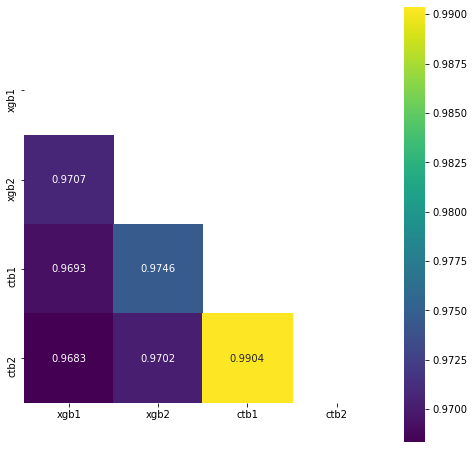

In [306]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [307]:
# AMean
scores_mean_am = scores.mean(axis=1)
score_am = roc_auc_score(my_train_old['TARGET'], scores_mean_am)
print(f"Score = {round(score_am, 4)}")


Score = 0.7342


In [308]:
# GMean
scores_mean_gm = gmean(scores, axis=1)
score_gm = roc_auc_score(my_train_old['TARGET'], scores_mean_gm)
print(f"Score = {round(score_gm, 4)}")

Score = 0.7342


In [ ]:
# Сделаем прогнозы моделей и соберем сабмит для Kaggle.

In [203]:
def mean_scores(scores, target):
    scores_list = [
        (scores.mean(axis=1), 'AMean score: '),
        (gmean(scores, axis=1), 'GMean score: '),
        (scores.rank().mean(axis=1), 'Rank  score: '),
        (gmean(scores.rank(), axis=1), 'GMean  rank: ')
    ]

    for scores_mean in scores_list:
        score = roc_auc_score(target, scores_mean[0])
        print(f"{scores_mean[1]}{score:.5f}")

In [309]:
#n_splist_crol_val=10

# prediction_1 = np.zeros(test_br.shape[0])
# for model in estimators_lgbm:
#     prediction_1 += model.predict_proba(test_br)[:, 1]
# prediction_1 = prediction_1/10

# prediction_12 = np.zeros(test_br.shape[0])
# for model in estimators_lgbm2:
#     prediction_12 += model.predict_proba(test_br)[:, 1]
# prediction_12 = prediction_12/10

prediction_2 = np.zeros(test_br.shape[0])
for model in xgb_estimators:
    prediction_2 += model.predict(dtest)
prediction_2 = prediction_2/10

prediction_21 = np.zeros(test_br.shape[0])
for model in xgb_estimators:
    prediction_21 += model.predict(dtest)
prediction_21 = prediction_21/10

prediction_3 = np.zeros(test_br.shape[0])
for model in estimators_ctb1:
    prediction_3 += model.predict_proba(test_br)[:, 1]
prediction_3 = prediction_3/10

prediction_4 = np.zeros(test_br.shape[0])
for model in estimators_ctb2:
    prediction_4 += model.predict_proba(test_br)[:, 1]
prediction_4 = prediction_4/10

scores_preds = pd.DataFrame({
#     "lgbm1": prediction_1,
#     "lgbm2": prediction_12,
    "xgb1": prediction_2,
    "xgb2": prediction_21,
    "ctb1": prediction_3,
    "ctb2": prediction_4
})

mean_scores(scores, gg['TARGET'])

AMean score: 0.73419
GMean score: 0.73419
Rank  score: 0.73384
GMean  rank: 0.73382


In [310]:
def cross_validation(model, X, y, cv):
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(X=x_train, y=y_train)
    
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {score:.5f}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print_scores(folds_scores)
    return estimators, oof_preds, np.mean(folds_scores)

In [311]:
def print_scores(folds_scores):
    print(f"Score by each fold: {folds_scores}")
    print(f"Mean score by each fold:{np.mean(folds_scores):.5f}")
    print("*" * 50)

In [312]:
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto', store_covariance=True, n_components=1)

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda, X=scores, y=my_train_old['TARGET'], cv=cv_strategy)

Fold 1, Valid score = 0.73404
Fold 2, Valid score = 0.72931
Fold 3, Valid score = 0.72988
Fold 4, Valid score = 0.72355
Fold 5, Valid score = 0.72940
Fold 6, Valid score = 0.74381
Fold 7, Valid score = 0.74144
Fold 8, Valid score = 0.74055
Fold 9, Valid score = 0.73446
Fold 10, Valid score = 0.72668
Fold 11, Valid score = 0.72501
Fold 12, Valid score = 0.73823
Fold 13, Valid score = 0.74672
Fold 14, Valid score = 0.74817
Score by each fold: [0.73404, 0.72931, 0.72988, 0.72355, 0.7294, 0.74381, 0.74144, 0.74055, 0.73446, 0.72668, 0.72501, 0.73823, 0.74672, 0.74817]
Mean score by each fold:0.73509
**************************************************


In [313]:
prediction_lda = np.zeros(test_br.shape[0])
for model in estimators_lda:
    prediction_lda += model.predict_proba(scores_preds)[:, 1]
prediction_lda = prediction_lda/len(estimators_lda)


In [314]:
len(prediction_lda)

165141

In [315]:
sample_submit = pd.read_csv(r"./competitive-data-analysis_coursework/sample_submit.csv")

sample_submit['TARGET'] = prediction_lda.tolist()

sample_submit.to_csv(r"./competitive-data-analysis_coursework/submitions/sport_kag_lite70.csv", index=False)
sample_submit

,APPLICATION_NUMBER,TARGET
0,123724268,0.036051
1,123456549,0.977454
2,123428178,0.155352
3,123619984,0.092434
4,123671104,0.023252
...,...,...
165136,123487967,0.093479
165137,123536402,0.039379
165138,123718238,0.086398
165139,123631557,0.025181


#### Вывод <a class='anchor' id='end'> 

В результате выполнения вышепроизведенных действий качество roc_auc на публичном лидерборде Kaggle составило 0.73600